In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1)
random.seed(1)

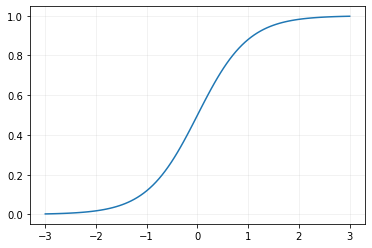

In [11]:
X = np.linspace(-3,3,100)
Y = 1 / (1 + np.exp(-2 * X))
plt.grid(alpha=0.2)

plt.plot(X,Y)

In [12]:
def p(k, i, xi, A, a, h, k2coord, Gt):
    return 1 / (1 + math.exp(-2 * I(k, i, xi, A, a, h, k2coord, Gt)))

def I(k, i, xi, A, a, h, k2coord, Gt):
    total = 0
    zeta = random.uniform(-1,1)  # sampled for each unique (k,i)
    for j in k2coord[k]:  # for each coordinate in cluster k
        eta = random.uniform(-1,1)  # different for each cell
        sigma = Gt[j]
        total += ((A*xi[k] + a*eta) * sigma) + h*zeta
    return (1 / len(k2coord[k])) * total

def cluster_info(arr):
    """ number of clusters (nonzero fields separated by 0s) in array
        and size of cluster
    """
    data = []
    k2coord = {}
    k = 0
    if arr[0] != 0: # left boundary
        data.append(0) # we will increment later in loop  
        k2coord[k] = []
    else:
        k=-1

    # print("arr", arr)
    # print("data", data)
    
    for i in range(0,len(arr)-1):
        if arr[i] == 0 and arr[i+1] != 0:
            data.append(0)
            k += 1
            k2coord[k] = []
        if arr[i] != 0:
            data[-1] += 1
            k2coord[k].append(i)
    if arr[-1] != 0:
        if data:  # if array is not empty
            data[-1] += 1  # right boundary
            k2coord[k].append(len(arr)-1)
        else:
            data.append(1)  
            k2coord[k] = [len(arr)-1]
            
    Ncl = len(data)  # number of clusters
    Nk = data  # Nk[k] = size of cluster k
    coord2k = {e:k for k,v in k2coord.items() for e in v}
    return Ncl, Nk, k2coord, coord2k

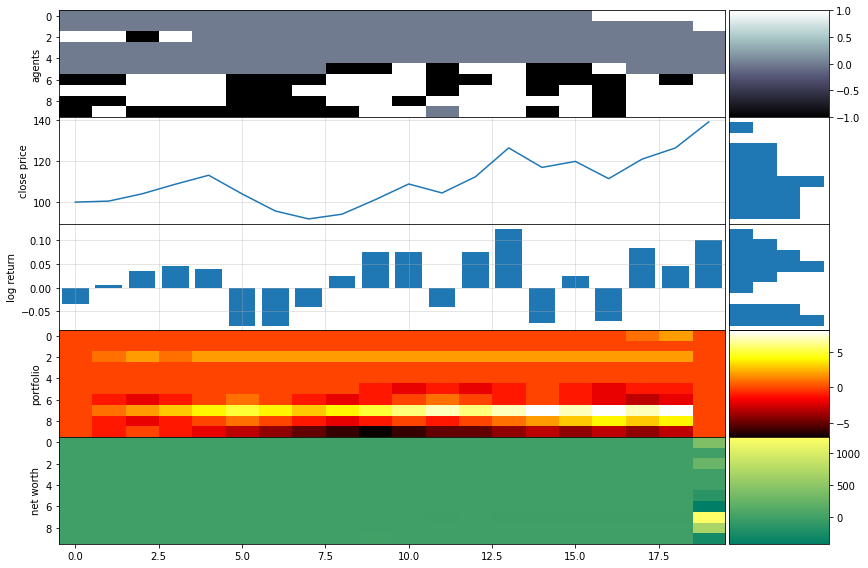

In [288]:
# pd = 0.25
# pe = 0.02
# ph = 0.18 # vary
pd = 0.1
pe = 0.0001
ph = 0.1 # vary

pa = 0.5

N0 = 20
N1 = 10

A = 2
a = 0.1
h = 0.1

G = np.zeros(shape=(N0,N1))
G[0] = np.random.choice(a=[-1,0,1], p=[pa/2, 1-pa, pa/2], size=N1, replace=True)

P = np.zeros_like(G)
V = np.zeros_like(G) # value of the owned stocks
N = np.zeros_like(G) # net worth

X = np.zeros(N0)
S = np.zeros(N0)
S[0] = 100

DRIFT = 0

for t in range(N0):
    Ncl, Nk, k2coord, coord2k = cluster_info(G[t])
    # print(k2coord, coord2k)
    # break
    xi = np.random.uniform(-1, 1, size=Ncl)  # unique xi for each cluster k
    # print(Ncl, Nk, k2coord, coord2k, xi)

    Xt = 0
    for k, size in enumerate(Nk):
        tmp = 0
        for i in k2coord[k]:
            tmp += G[t,i]
        Xt += size * tmp
    X[t] = Xt/(10*N0)
    if t > 0:
        # Close price of today = Close price of yesterday + todays log return
        S[t] = S[t-1] + (S[t-1] * X[t]) + DRIFT
    

    if t == N0-1:
        # last iteration, we stop
        # before we stop, traders buy back / sell all shares in portfolio at current price
        # their worth (V) decreases if their portfolio P is negative (so they buyback shares)
        # their worth (V) increases if their portfolio P is positive (so they sell shares)
        # V[t] = V[t] + (P[t] * S[t])
        # sellbuy = -P[t]
        # V[t] = V[t] + (-P[t] * S[t])
        # V[t] = V[t] + (P[t] * S[t]) * (-1)
        V[t] = P[t,i] * S[t]
        # N[t] = N[t-1] + (P[t] * S[t])
        N[t] = (P[t] * S[t])
        P[t] = 0

        break

    for i in range(N1):
        P[t+1,i] = P[t,i] + G[t,i]
        # value of portfolio = (buy or sell) * (current price) * (-1)
        # because buy = 1, but buying removes money so should be -1
        # sell = -1 but sell adds money so 1
        # V[t+1,i] = V[t,i] + (G[t,i] * S[t] * (-1))
        V[t,i] = P[t,i] * S[t]
        N[t,i] = - P[t,i]

        # traders update their stance
        if G[t,i] != 0:
            k = coord2k[i]
            # print(k)
            pp = p(k, i, xi, A, a, h, k2coord, G[t])
            if random.random() < pp:
                G[t+1,i] = 1
            else:
                G[t+1,i] = -1

        
        # trader influences non-active neighbour to join
        if G[t,i] != 0:
            stance = G[t,i]
            if random.random() < ph:
                if G[t,(i-1)%N1] == 0 and G[t,(i+1)%N1] == 0:
                    ni = np.random.choice([-1,1])
                    G[t+1,(i+ni)%N1] = stance#random.choice([-1,1])
                elif G[t,(i-1)%N1] == 0:
                    G[t+1,(i-1)%N1] = stance#random.choice([-1,1])
                elif G[t,(i+1)%N1] == 0:
                    G[t+1,(i+1)%N1] = stance#random.choice([-1,1])
                else:
                    continue

        # active trader diffuses if it has inactive neighbour
        # only happens at edge of cluster
        if G[t,i] != 0:
            if random.random() < pd:
                if (G[t,(i-1)%N1] == 0) or (G[t,(i+1)%N1] == 0):
                    G[t+1,i] = 0
                else:
                    continue

        # nontrader enters market
        if G[t,i] == 0:
            if random.random() < pe:
                G[t+1,i] = np.random.choice([-1,1])

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(
    ncols=1, nrows=5, figsize=(12,8), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}
)
im1 = ax1.imshow(G.T, cmap="bone", interpolation="None", aspect="auto")
im4 = ax4.imshow(P.T, cmap="hot", interpolation="None", aspect="auto")
im5 = ax5.imshow(N.T, cmap="summer", interpolation="None", aspect="auto")

size = "15%"

cax1 = make_axes_locatable(ax1).append_axes('right', size=size, pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
cax4 = make_axes_locatable(ax4).append_axes('right', size=size, pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
cax5 = make_axes_locatable(ax5).append_axes('right', size=size, pad=0.05)
fig.colorbar(im5, cax=cax5, orientation='vertical')

cax2 = make_axes_locatable(ax2).append_axes('right', size=size, pad=0.05)
cax2.hist(S, orientation="horizontal", bins=np.linspace(np.min(S), np.max(S), len(S)//2))
cax2.get_xaxis().set_visible(False)
cax2.get_yaxis().set_visible(False)

cax3 = make_axes_locatable(ax3).append_axes('right', size=size, pad=0.05)
cax3.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//2))
cax3.get_xaxis().set_visible(False)
cax3.get_yaxis().set_visible(False)

# for ax in (ax2,ax3):
#     cax = make_axes_locatable(ax).append_axes('right', size=size, pad=0.05)
#     # cax.axis('off')




ax2.plot(S)
ax2.grid(alpha=0.4)

ax3.bar(np.arange(len(X)), X)
ax3.grid(alpha=0.4)

ax4.set_xlabel("time")
# ax2.set_ylabel("standardised log returns")
ax2.set_ylabel("close price")
ax1.set_ylabel("agents")
ax3.set_ylabel("log return")
ax4.set_ylabel("portfolio")
ax5.set_ylabel("net worth")

# fig.colorbar(im, cax=ax4)

plt.tight_layout()
plt.show()

(array([4., 0., 0., 6., 1., 0., 6., 0., 0., 7., 6., 2., 7., 0., 3., 1., 1.,
        0., 0., 0., 5., 0., 0., 1.]),
 array([-0.098     , -0.08983333, -0.08166667, -0.0735    , -0.06533333,
        -0.05716667, -0.049     , -0.04083333, -0.03266667, -0.0245    ,
        -0.01633333, -0.00816667,  0.        ,  0.00816667,  0.01633333,
         0.0245    ,  0.03266667,  0.04083333,  0.049     ,  0.05716667,
         0.06533333,  0.0735    ,  0.08166667,  0.08983333,  0.098     ]),
 <BarContainer object of 24 artists>)

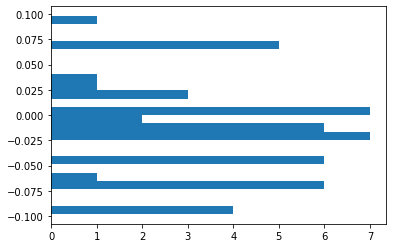

In [264]:
plt.hist(X, orientation="horizontal", bins=np.linspace(np.min(X), np.max(X), len(X)//2))

In [64]:
print(np.mean(G))
np.mean(G, axis=0)

-0.02916


array([ 0.084, -0.036, -0.128, -0.02 ,  0.064,  0.008, -0.012, -0.052,
       -0.004, -0.096, -0.088, -0.052, -0.008, -0.048, -0.028,  0.004,
       -0.092, -0.084, -0.016, -0.044, -0.056,  0.004,  0.032, -0.036,
       -0.112, -0.064, -0.016,  0.008, -0.012, -0.048, -0.028, -0.12 ,
        0.04 , -0.072, -0.048, -0.064, -0.048,  0.   , -0.064, -0.036,
       -0.032, -0.008, -0.076,  0.024, -0.052, -0.044,  0.036, -0.08 ,
        0.   , -0.064, -0.044, -0.024, -0.036, -0.088, -0.02 , -0.024,
       -0.008, -0.116, -0.016, -0.016,  0.   , -0.068, -0.076, -0.02 ,
        0.004, -0.036,  0.   ,  0.028,  0.04 , -0.068,  0.072,  0.008,
       -0.124, -0.02 , -0.056,  0.04 , -0.056,  0.008, -0.02 , -0.036,
       -0.056, -0.088,  0.072,  0.004, -0.04 , -0.032, -0.04 , -0.048,
        0.032, -0.024,  0.008, -0.016, -0.016,  0.004,  0.004, -0.068,
       -0.072, -0.048, -0.032, -0.004])

- look at buys and sells
\\